In [38]:
from collections import Counter
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from helper import Preprocess
from sklearn.neighbors import NearestNeighbors
from numpy import linalg as LA

from sklearn.manifold import TSNE

we first explore the original graph (before embedding)

In [110]:
DATA_FOLDER = Path("../../data/")
data_processor = Preprocess()
df = data_processor.raw2train(DATA_FOLDER)

G_original = nx.from_pandas_edgelist(df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
print(nx.info(G_original))

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (954968, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 390088
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------
Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 761241
Average degree:  81.9729


We first map the vectors in embedded space to a graph using KNN algorithm

In [2]:
emb_df = pd.read_csv('./emb/128_relu_40_adjacentTF_3e-5.csv', index_col=0)
emb_df = emb_df.drop(['type'], axis='columns')

# map node index to node name
idx = emb_df.index
idx2name = dict()
for i, name in enumerate(idx):
    idx2name[i] = name
emb = emb_df.to_numpy()

# use KNN to find nearest neighbors of every node
print('Running KNN...')
nbrs = NearestNeighbors(n_neighbors=40, algorithm='ball_tree').fit(emb)
distance, indices = nbrs.kneighbors(emb)
print('KNN completed!')

# create edgelist
edgelist = []
print('Creating edgelist...')
for i, name in enumerate(idx):
    for j in range(len(indices[i])):
        temp = []
        if j != 0:
            temp.append(name)
            temp.append(idx2name[indices[i][j]])
            temp.append(distance[i][j])
            edgelist.append(temp)

edgelist_df = pd.DataFrame(edgelist)
edgelist_df.columns = ['source', 'target', 'distance']
edgelist_df['weight'] = edgelist_df['distance'].map(lambda x: 1-x)
edgelist_df.shape

edgelist_df.head()

Running KNN...
KNN completed!
Creating edgelist...


source    target  distance    weight
0  MCHR1     WFDC2  0.418602  0.581398
1  MCHR1     TFPI2  0.443282  0.556718
2  MCHR1  Z97053.1  0.445599  0.554401
3  MCHR1    LY6G6E  0.445872  0.554128
4  MCHR1     CHRNG  0.446104  0.553896

In [3]:
G = nx.from_pandas_edgelist(edgelist_df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 646110
Average degree:  69.5752


In [4]:
# Run Louvein algorithm for clustering
partition = community_louvain.best_partition(G)
max(set(partition.values()))

10

Now we have a clustered network based on the embedding of each node, we create a new column to record class of each node.

In [25]:
emb_df['class'] = emb_df.index.map(lambda x: partition[x])
cluster_df = emb_df[['class']].copy(deep=True)
cluster_df.groupby(['class'])
def is_tf(name):
    if name[-3:] == '_gm':
        return 2
    elif name[-2:] == '_k':
        return 1
    else:
        return 0
cluster_df['is_tf'] = cluster_df.index.map(lambda name: is_tf(name))

gm_cluster_df = cluster_df[cluster_df['is_tf'] == 2]
k_cluster_df = cluster_df[cluster_df['is_tf'] == 1]
gene_cluster_df = cluster_df[cluster_df['is_tf'] == 0]

print('Cluster of K: ', Counter(k_cluster_df['class']))
print('Cluster of GM: ', Counter(gm_cluster_df['class']))
print('Cluster of normal gene: ', Counter(gene_cluster_df['class']))

Cluster of K:  Counter({10: 69})
Cluster of GM:  Counter({10: 69})
Cluster of normal gene:  Counter({2: 5173, 6: 3787, 5: 2948, 1: 1920, 4: 1848, 3: 824, 0: 790, 7: 640, 8: 294, 9: 211})


In [67]:
mean_clusters = emb_df.groupby('class').mean()

all_embeddings = emb_df.drop(['class'], axis=1).append(mean_clusters)

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=all_embeddings.index)

print('Mapping names to classes...')
def name2class(name):
    if type(name) == int:
        return 10
    else:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
        else:
            return 0
emb_transformed['type'] = emb_transformed.index.map(name2class)
emb_transformed



Running TSNE...
Mapping names to classes...


0          1  type
MCHR1   17.220955  22.757914     0
PSMD9  -49.867085 -24.056856     0
CRIP1   10.175576 -45.558720     0
GIMAP4  11.850396 -50.336536     0
GATM    -3.309110  48.964321     0
...           ...        ...   ...
6        9.028999 -53.272533    10
7        5.273890   2.363193    10
8       17.730909  32.575745    10
9        5.577220  32.278183    10
10     -45.877602  53.284554    10

[18584 rows x 3 columns]

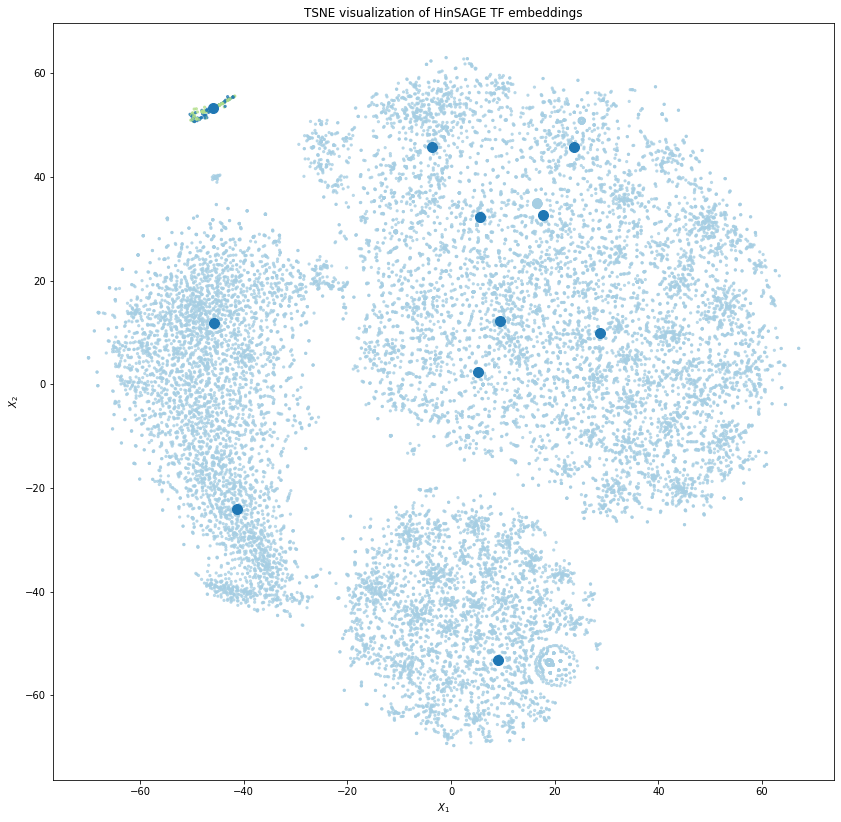

In [74]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=5
)
ax.scatter(
    emb_transformed[emb_transformed['type'] == 10][0],
    emb_transformed[emb_transformed['type'] == 10][1],
    s=100
)



# # mark out some nodes
# target_nodes = ['MYC', 'YBX1', 'MAFK', 'NBN']
# target_txts = []
# for n in target_nodes:
#     target_txts.append(n + '_k')
#     target_txts.append(n + '_gm')
# for i, txt in enumerate(nodes):
#     if txt in target_txts or False:
#         ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))


ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE TF embeddings")

# plt.savefig(f'./img/{file_name}_TF.png', dpi=150)
plt.show()

We could calculate the distance between clusters

In [75]:
mean_clusters = emb_df.groupby('class').mean()
tf_class = set(gm_cluster_df['class']).union(k_cluster_df['class'])
try:
    assert(len(tf_class) == 1)
except:
    print('Error: TFs belong to more than one class')
tf_mean_emb = mean_clusters.loc[tf_class.pop()].to_numpy()


mean_clusters['dist_to_tf'] = mean_clusters.apply(lambda x: LA.norm(tf_mean_emb - x.to_numpy()), axis=1)
mean_clusters

0         1         2         3         4         5         6  \
class                                                                         
0      0.043981  0.002498  0.047174  0.004521  0.046103  0.051771  0.071132   
1      0.042268  0.006968  0.048971  0.000364  0.071181  0.022206  0.039056   
2      0.043015  0.001278  0.057984  0.000278  0.060777  0.016007  0.022958   
3      0.020060  0.019116  0.032116  0.000904  0.014382  0.029778  0.062964   
4      0.018109  0.000509  0.022477  0.000053  0.022572  0.005940  0.009264   
5      0.016707  0.001162  0.020370  0.000096  0.023363  0.006597  0.009902   
6      0.009946  0.000372  0.014020  0.000013  0.013859  0.003340  0.005082   
7      0.020818  0.034564  0.066638  0.001797  0.024626  0.039922  0.018775   
8      0.018977  0.002805  0.021594  0.000580  0.042764  0.024294  0.006131   
9      0.019850  0.001706  0.024534  0.001221  0.094512  0.015602  0.009962   
10     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              7         8         9  ...       119       120       121  \
class                                ...                                 
0      0.017526  0.064452  0.041796  ...  0.000400  0.071567  0.087658   
1      0.008415  0.029936  0.020081  ...  0.000731  0.066799  0.081293   
2      0.014774  0.038297  0.016425  ...  0.000521  0.071481  0.086558   
3      0.019207  0.020845  0.042747  ...  0.000665  0.072259  0.088112   
4      0.008021  0.016985  0.006394  ...  0.318166  0.064536  0.102102   
5      0.005532  0.016372  0.006519  ...  0.439420  0.112550  0.117709   
6      0.004826  0.010138  0.004116  ...  0.023348  0.003292  0.041367   
7      0.041347  0.030730  0.037974  ...  0.000616  0.074383  0.090410   
8      0.033626  0.070389  0.009184  ...  0.000109  0.075611  0.092712   
9      0.008527  0.058808  0.031485  ...  0.000000  0.071060  0.086374   
10     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

            122       123       124       125       126       127  dist_to_tf  
class                                                                          
0      0.058699  0.170009  0.137241  0.000000  0.095055  0.062413    0.884646  
1      0.054738  0.158564  0.127871  0.000000  0.088899  0.058020    0.892998  
2      0.058073  0.168581  0.136009  0.000000  0.094590  0.061907    0.853127  
3      0.059013  0.171443  0.138557  0.000000  0.096201  0.063068    0.884628  
4      0.003234  0.000000  0.071712  0.000000  0.038836  0.007159    1.182861  
5      0.002080  0.002947  0.075211  0.000000  0.201688  0.000371    1.194136  
6      0.121271  0.000000  0.035884  0.000000  0.000076  0.184519    1.303226  
7      0.060915  0.175965  0.142341  0.000000  0.098455  0.064651    0.886753  
8      0.062582  0.181123  0.146366  0.000000  0.100050  0.066609    0.900563  
9      0.058266  0.169202  0.136769  0.000000  0.094731  0.062056    0.907305  
10     0.000000  0.192572  0.127682  0.364587  0.000000  0.000000    0.000000  

[11 rows x 129 columns]